### Covid-19 Infection Counts Exploration
* author   : santosh
* date     : 05.04.2020
* purpose  : run country level trends (Infections, Recovery, Deaths)
* instance : local

<font color='tan'> setup

In [97]:
#import dependencies
#data wrangling
import numpy as np
import pandas as pd
import dfply as dfp
import datetime as dt
#plot
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sb
#helper funcs
from helper_funcs import isUnique

In [2]:
#display options
pd.options.display.html.table_schema = True
pd.set_option('display.max_rows', 999)
# %matplotlib inline

<font color='tan'> ingest scrubbed analysis data

In [25]:
#read csv file
country_df = pd.read_csv('../data/covid19_country_analysis_data.csv', sep=',', parse_dates=['Date'])

In [26]:
#check dtypes
country_df.dtypes

Confirmed                  int64
Confirmed_New            float64
Country_Region            object
Date              datetime64[ns]
Deaths                     int64
Deaths_New               float64
Recovered                  int64
Recovered_New            float64
year                       int64
month                      int64
year_month                object
dtype: object

In [27]:
#ensure counts are not below zero
country_df['Confirmed_New'] = country_df['Confirmed_New'].apply(lambda x:max(0,x))
country_df['Deaths_New'] = country_df['Deaths_New'].apply(lambda x:max(0,x))
country_df['Recovered_New'] = country_df['Recovered_New'].apply(lambda x:max(0,x))

In [28]:
#check uniqueness
print('\nanalysis data unique in Country and Date: ',isUnique(country_df, ['Country_Region','Date']))


analysis data unique in Country and Date:  True


<font color='tan'> user inputs

In [153]:
#user input - number of countries to display
topsel = input('Choose number of countries you want to display: enter a number b.w. 1 and 10')
print('\nyou chose: ',topsel)

Choose number of countries you want to display: enter a number b.w. 1 and 104

you chose:  4


In [154]:
#user input - metric to plot
metric_cum = input("Choose the cumulative Covid-19 metric you want: 'Confirmed','Deaths' or 'Recovered'")
print('\nyou chose: ',metric_cum)

Choose the cumulative Covid-19 metric you want: 'Confirmed','Deaths' or 'Recovered'Confirmed

you chose:  Confirmed


In [155]:
#choose metric
metric_new = input("Choose the daily Covid-19 metric you want: 'Confirmed_New','Deaths_New' or 'Recovered_New'")
print('\nyou chose: ',metric_new)

Choose the daily Covid-19 metric you want: 'Confirmed_New','Deaths_New' or 'Recovered_New'Confirmed_New

you chose:  Confirmed_New


In [156]:
#create list of top countries (with and without US)
topnum = int(topsel) #select how many countries to display

#including US
top = country_df.groupby(['Country_Region'],as_index=False)\
.agg({metric_cum:'max'})\
.sort_values(by=[metric_cum], ascending=False)\
.head(topnum)['Country_Region']\
.tolist()

#excluding US
top_xus = country_df.loc[country_df['Country_Region'] != 'US']\
.groupby(['Country_Region'],as_index=False)\
.agg({metric_cum:'max'})\
.sort_values(by=[metric_cum], ascending=False)\
.head(topnum)['Country_Region']\
.tolist()

In [157]:
#user input - select 'top' or 'top_xus'
list_sel = top
#list_sel = top_xus

<font color='tan'> plot cumulative trends

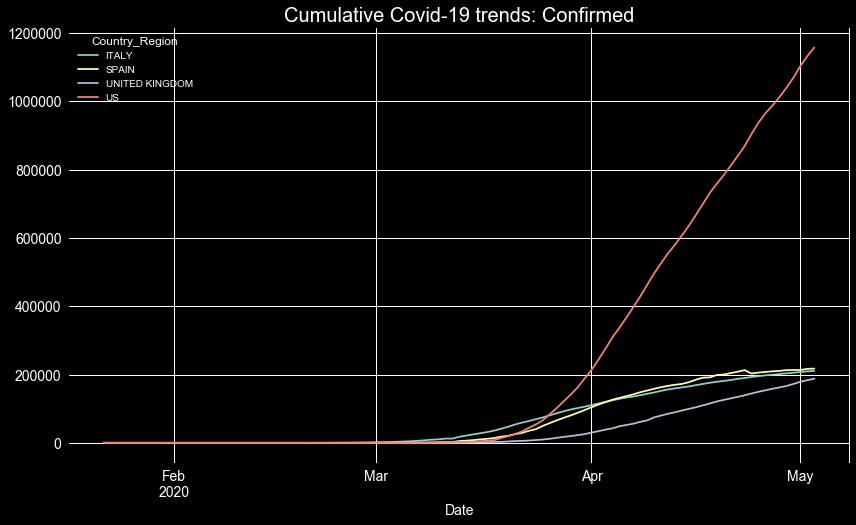

In [158]:
#filter and transpose data
p_df = country_df.loc[country_df['Country_Region'].isin(list_sel)]\
.pivot_table(values=metric_cum, index=['Date'], columns='Country_Region')\
.reset_index().fillna(0)
p_df.set_index('Date', inplace=True)

#plot
p_df.plot.line(figsize=(14,8))
plt.title('Cumulative Covid-19 trends: '+metric_cum, size=20)
plt.xlabel('Date',size=14)
plt.xticks(size=14, color='white')
plt.yticks(size=14, color='white')
plt.show()

<font color='tan'> plot daily trends

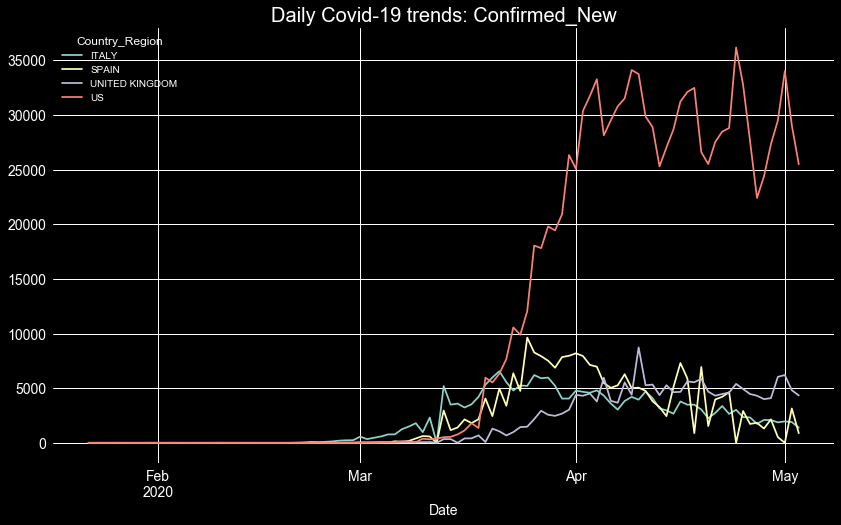

In [159]:
#filter and transpose data
p_df = country_df.loc[country_df['Country_Region'].isin(list_sel)]\
.pivot_table(values=metric_new, index=['Date'], columns='Country_Region')\
.reset_index().fillna(0)
p_df.set_index('Date', inplace=True)

#plot
p_df.plot.line(figsize=(14,8))
plt.title('Daily Covid-19 trends: '+metric_new, size=20)
plt.xlabel('Date',size=14)
plt.xticks(size=14, color='white')
plt.yticks(size=14, color='white')
plt.show()

<font color='tan'> add trendline to daily new cases

In [170]:
p_df = country_df.loc[country_df['Country_Region'].isin(list_sel)]
p_df['days_since_jan22'] = (p_df['Date'] - p_df['Date'].min()).dt.days
#plot
def getTrend(country):
    """
    returns a seaborn lmplot of daily metric
    """
    df = p_df.loc[p_df['Country_Region'] == country]
    sb.lmplot(x='days_since_jan22', y=metric_new, data=df, lowess=True, aspect=20/9, line_kws={'color': 'red'})
    plt.title(' Daily Covid-19 cases: '+country+' : '+metric_new, size=20)
    plt.xlabel('Days since Jan-22', size=14)
    plt.xticks(size=14, color='white')
    plt.yticks(size=14, color='white') 
    plt.show()

/Users/santossa/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


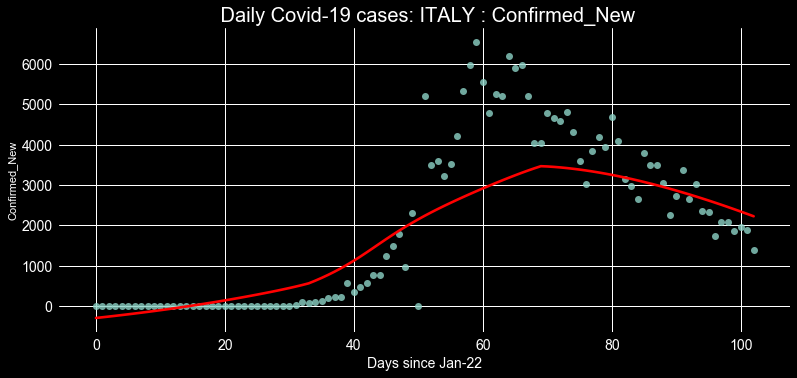

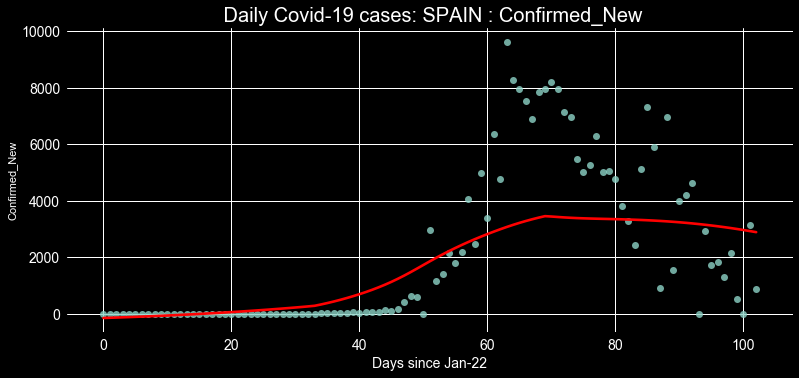

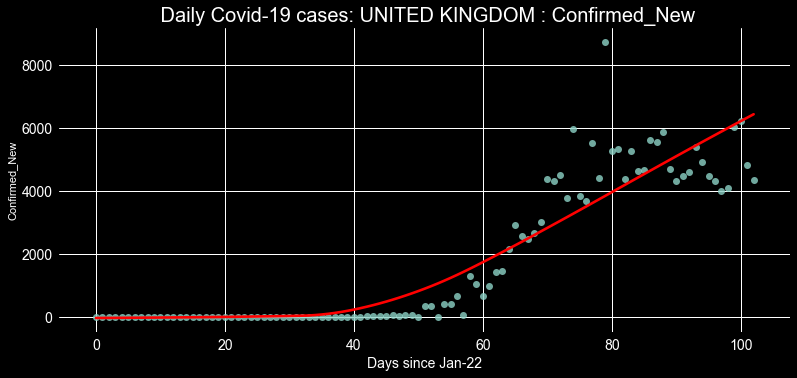

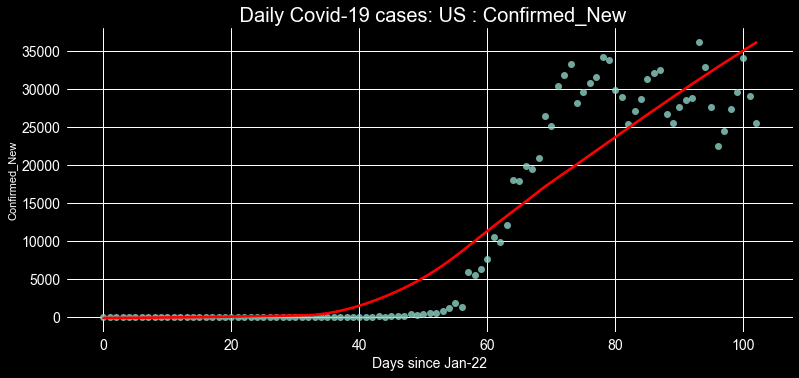

In [171]:
list_country = p_df['Country_Region'].unique()
for item in list_country:
    getTrend(item)

<font color='tan'> end